# 4. Pretraining LLMs

In [1]:
import tiktoken
import torch
import matplotlib 
import numpy

### Using GPT to generate text

- Initialize the GPT model.
- We use dropout of 0.1 or above, but it is reletavely common to train LLM without dropout nowadays. 
- Modern LLMs don't use bias vectors in the `nn.Linear` layer for the QKV materices, hence we set `qkv_bias: False`.
- We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens.
- Next, we use the generate_text_simple function from the previous chapter to generate text.
- In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

In [2]:
import torch 
from supplementary import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

<img src="./metadata/09.png" alt=" " style="display: block; margin: 0 auto; width:800px; height:auto;" />


In [3]:
import tiktoken
from supplementary import generate_text_simple

def text_to_token(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<endoftext>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimesion
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove the added batch dim
    return tokenizer.decode(flat.tolist())

In [4]:
start_context = "every effor moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token(tokenizer=tokenizer, text=start_context),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text \n", token_ids_to_text(token_ids, tokenizer))

Output text 
 every effor moves you (% LGBT Telegram Superman communities Observatoryelse Constant berelevision


- ohhh..that's one way to generate text....
- As we can see above, the model does not produce good text because it has not been trained yet
- How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress

### 2. Preparing the dataset loaders
 
- We use a relatively small dataset for training the LLM (in fact, only one short story)

In [ ]:
with open("datasets/the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

# First 100 characters
print(text_data[:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [7]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)
- For visualization purposes, the figure below assumes a max_length=6, but for the training loader, we set the max_length equal to the context length that the LLM supports

<img src="./metadata/10.png" alt=" " style="display: block; margin: 0 auto; width:900px; height:auto;" />


In [11]:
from sympy import true
from supplementary import create_dataloader_v1

# Train/Validation ratio
train_ratio = 0.9
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=2
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=2
)

We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with

In [13]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens+=input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens+=input_batch.numel()

print("Total train tokens : ", train_tokens)
print("Total val tokens : ", val_tokens)

Total train tokens :  4608
Total val tokens :  512


Next, let's calculate the initial loss before we start training

In [14]:
from supplementary import calc_loss_loader
device = "cuda"
model.to(device)

torch.manual_seed(123) # reproducability because of shuffeling of data loader

with torch.no_grad(): # disabling gradient tracking cause we're not trainig yet.
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583266364204
Validation loss: 10.98110580444336


### 3. Training an LLM

<img src="./metadata/11.png" alt=" " style="display: block; margin: 0 auto; width:500px; height:auto;" />


In [15]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

- Now, let's train the LLM using the training function defined above:

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.823, Val loss 9.928
Ep 1 (Step 000005): Train loss 7.923, Val loss 8.336
Every effort moves you,.                                                
Ep 2 (Step 000010): Train loss 6.583, Val loss 7.038
Ep 2 (Step 000015): Train loss 5.983, Val loss 6.593
Every effort moves you, the, and, the, the, the, the, the. ", the,,, the, and, the, of the, the, the, the, the, the, the, and, the, and, the
Ep 3 (Step 000020): Train loss 15.806, Val loss 15.890
Ep 3 (Step 000025): Train loss 5.594, Val loss 6.463
Every effort moves you. Gis. Gis. Gis. I had. G. I had, and--, and--. I had. G. I had. I had to the his--. I had. I had been. I had. I
Ep 4 (Step 000030): Train loss 4.984, Val loss 6.325
Ep 4 (Step 000035): Train loss 4.731, Val loss 6.247
Every effort moves you, and "I was a--I to the picture. "--and, I had to the picture. "I to the the, I had the picture, I had the picture, I had the picture. "I had
Ep 5 (Step 000040): Train loss 4.196, Val loss 6.257
Every e

In [17]:
torch.save(model.state_dict(), "model.pth")

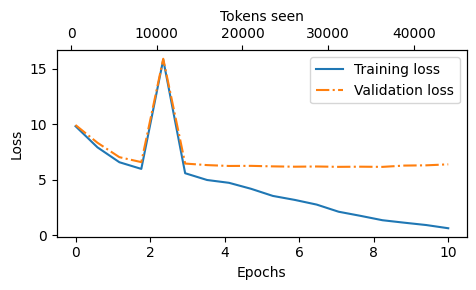

In [18]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences

- However, based on the training and validation set losses, we can see that the model starts overfitting

- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data

- There are decoding strategies (not covered in this workshop) that can mitigate this memorization by a certain degree

- Also note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times


**Load the trained model and generate text**

In [19]:
import torch

# Imports from a local file
from supplementary import GPTModel


model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval();

In [22]:
from supplementary import text_to_token_ids

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

token_ids = generate_text_simple(
    model=model.to(device),
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to
